# Applying Bayesian Hierarchical Regression to Reevaluate Concrete Strength Forecasting

Outlines : 
- Step Before Fitting Model
- During Fitting Model
- Evaluating Model
- Comparing Model

References : 
- [Bayesian Data Analysis](http://www.stat.columbia.edu/~gelman/book/BDA3.pdf)
- [Bayesian Workflow](https://arxiv.org/abs/2011.01808)




So far we have seen that there are lot of things to debug in Bayesian Modeling. In order to model working properly and could answer our objective , we need to carefully check our model. 





In [1]:
!pip install pymc xarray pyreadr

/usr/bin/pip:6: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import load_entry_point


In [7]:
%matplotlib inline
import pymc as pm
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import xarray as xr
import pyreadr
import logging
import tqdm

%config InlineBackend.figure_format = 'retina'
# plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

in this phase, we will be using **Concrete Strenght** Dataset


So what is our task ? 

Our task is to predict the

In [8]:
data = pd.read_csv("https://raw.githubusercontent.com/axeltanjung/concrete_strengh_bayes/main/dataset/concrete_date.csv")

numerical_features = ['cement', 'slag', 'flyash', 'water', 'superplasticizer','coarseaggregate', 'fineaggregate', 'age']

In [9]:
data

cement   slag  flyash  water  superplasticizer  coarseaggregate  \
0      540.0    0.0     0.0  162.0               2.5           1040.0   
1      540.0    0.0     0.0  162.0               2.5           1055.0   
2      332.5  142.5     0.0  228.0               0.0            932.0   
3      332.5  142.5     0.0  228.0               0.0            932.0   
4      198.6  132.4     0.0  192.0               0.0            978.4   
...      ...    ...     ...    ...               ...              ...   
1025   276.4  116.0    90.3  179.6               8.9            870.1   
1026   322.2    0.0   115.6  196.0              10.4            817.9   
1027   148.5  139.4   108.6  192.7               6.1            892.4   
1028   159.1  186.7     0.0  175.6              11.3            989.6   
1029   260.9  100.5    78.3  200.6               8.6            864.5   

      fineaggregate  age  csMPa  
0             676.0   28  79.99  
1             676.0   28  61.89  
2             594.0  270  40.27  
3             594.0  365  41.05  
4             825.5  360  44.30  
...             ...  ...    ...  
1025          768.3   28  44.28  
1026          813.4   28  31.18  
1027          780.0   28  23.70  
1028          788.9   28  32.77  
1029          761.5   28  32.40  

[1030 rows x 9 columns]

## Before Fitting Model

### 1. Exploratory Data Analysis 


First we need to understand our variable relation with what we are going to predict



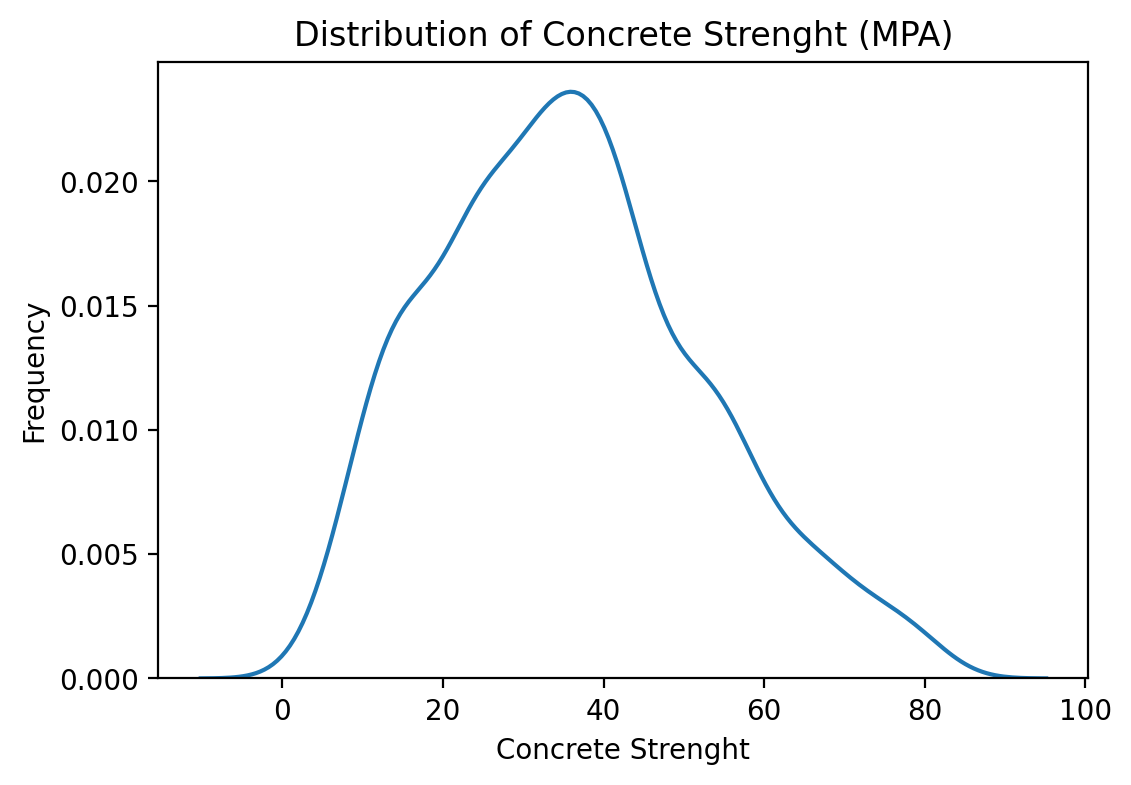

In [10]:
# Visualize the distribution of the target variable
plt.figure(figsize=(6, 4))
sns.kdeplot(data['csMPa'])
plt.title('Distribution of Concrete Strenght (MPA)')
plt.xlabel('Concrete Strenght')
plt.ylabel('Frequency')
plt.show()

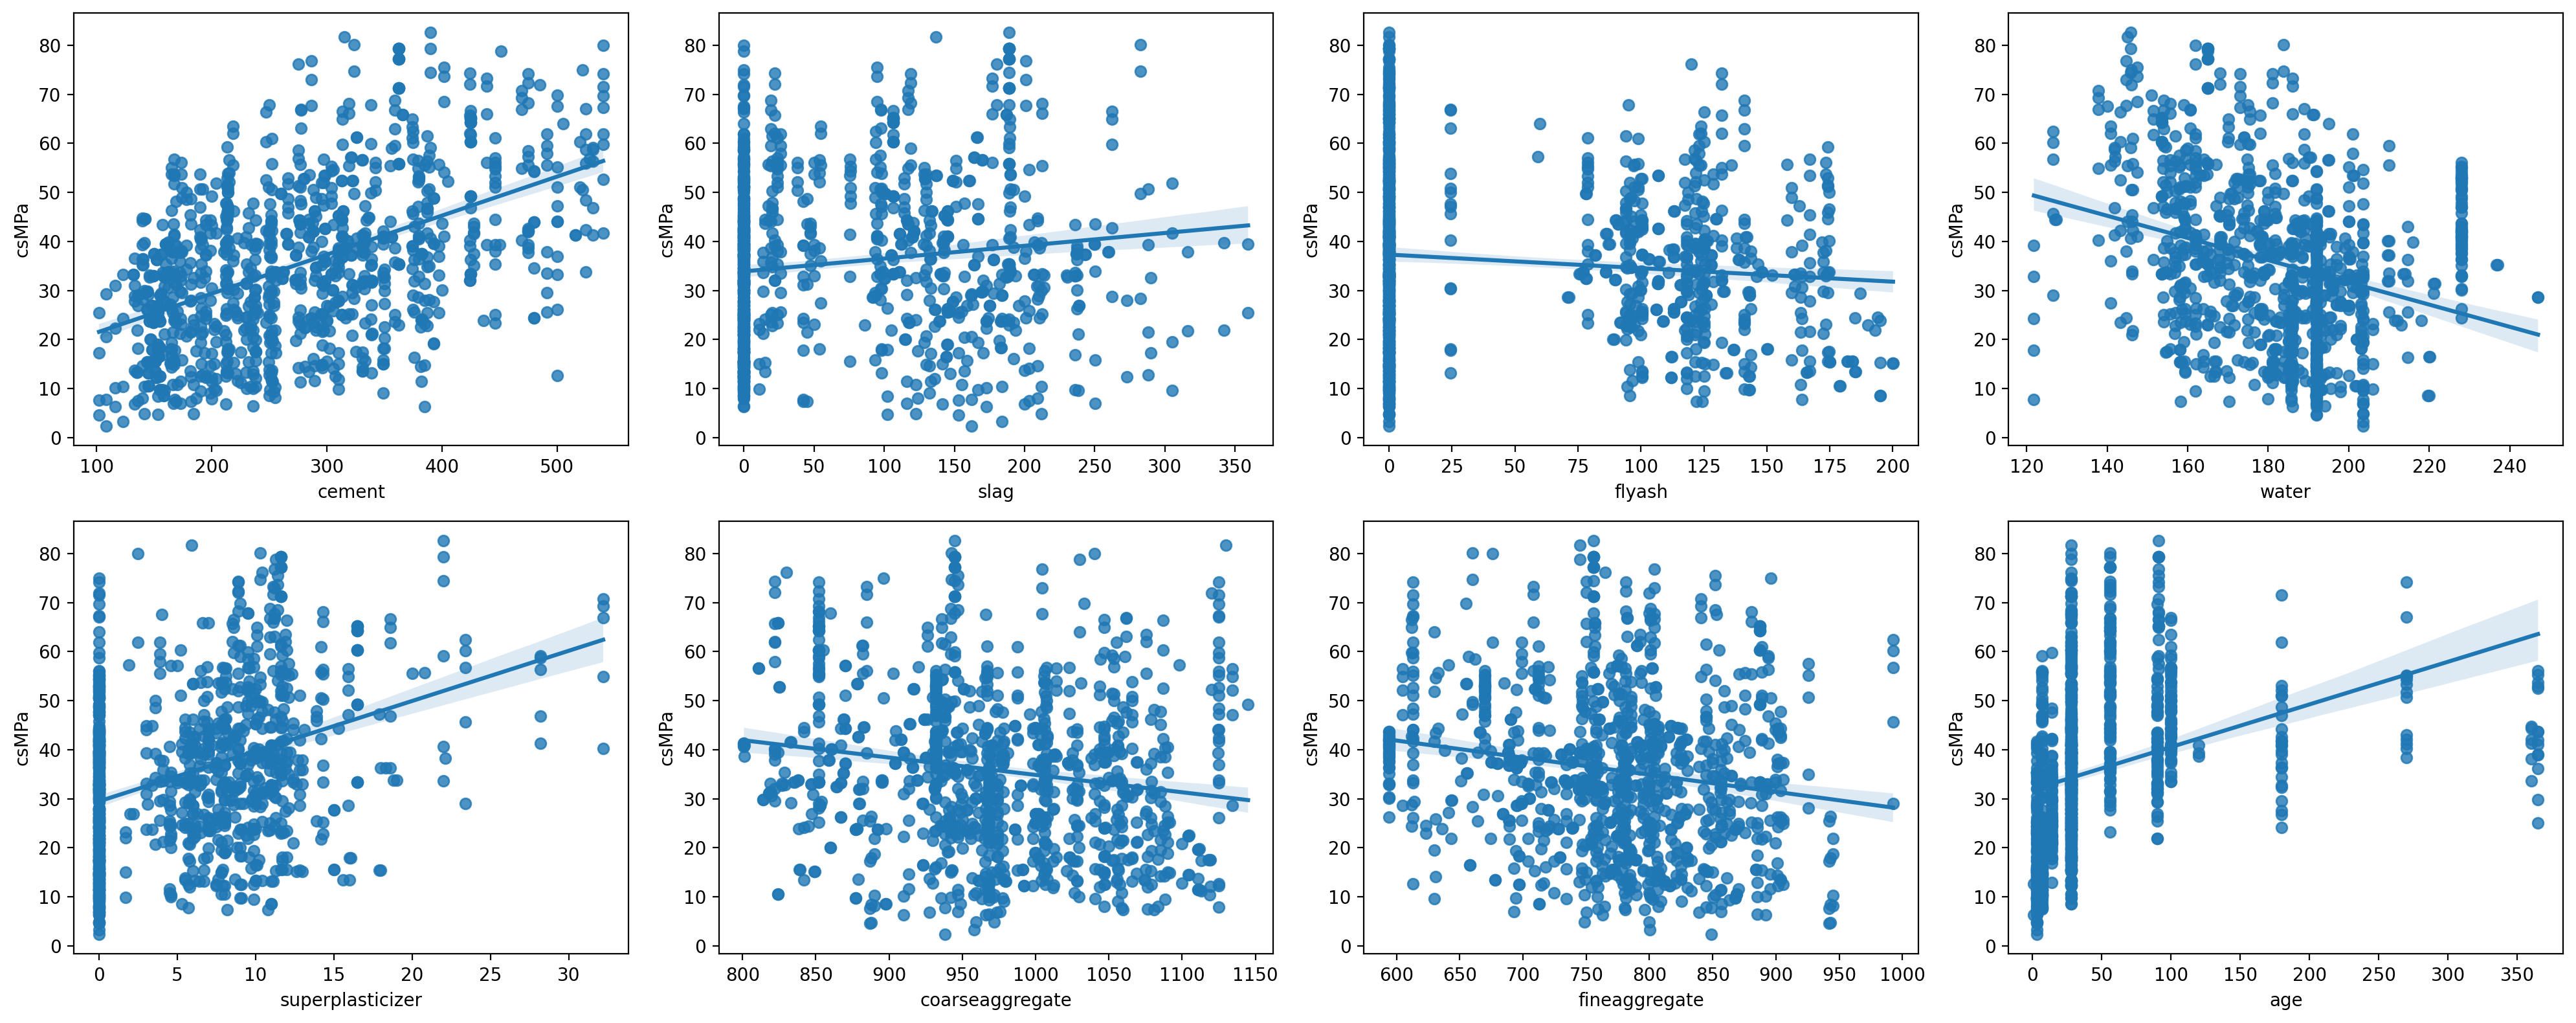

In [11]:
# Assume numerical_features is a list of feature names
num_features = len(numerical_features)
num_cols = (num_features + 1) // 2  # Determine the number of columns in each row
num_rows = 2  # Two rows

# Create subplots with the desired number of rows and columns
fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 8))

# Flatten the axes array for easier indexing
ax = ax.flatten()

# Plot each feature
for idx in range(num_features):
    sns.regplot(data=data, x=numerical_features[idx], y="csMPa", ax=ax[idx])

# Hide any unused subplots if the number of features is less than the number of subplot slots
for idx in range(num_features, len(ax)):
    ax[idx].axis('off')

plt.tight_layout()
plt.show()

### 2. Choosing Initial Model 

There are lot of varity of model we can use, however ar first we should try the simplest one at first, for example we can use thcementre to predict thconcrete strenghtes

**Simple Model**

$rides =  \alpha + \beta * temperature$

### 3. Scaling and Transforming Parameter 



Why then scaling needed ? 
For easier choose of prior we can perform scaling, for example if we normalized our data into $X \sim Normal(\mu=1,\sigma=1)$ 


1. Scale Free --> ease at spesifying prior , we can use such standard normal prior
2. Interpretation --> for example we want to scale the outcome as we want to explain / interpret the regression coefficient in terms of log scale which are more intuitive


now, let's scale both our predictor and outcome variables to log scale 

In [12]:
data['log_csMPa'] = np.log1p(data['csMPa']).astype(dtype=np.float128)
data['log_cement'] = np.log1p(data['cement']).astype(dtype=np.float128)

Text(0.5, 1.0, 'Original Scale')

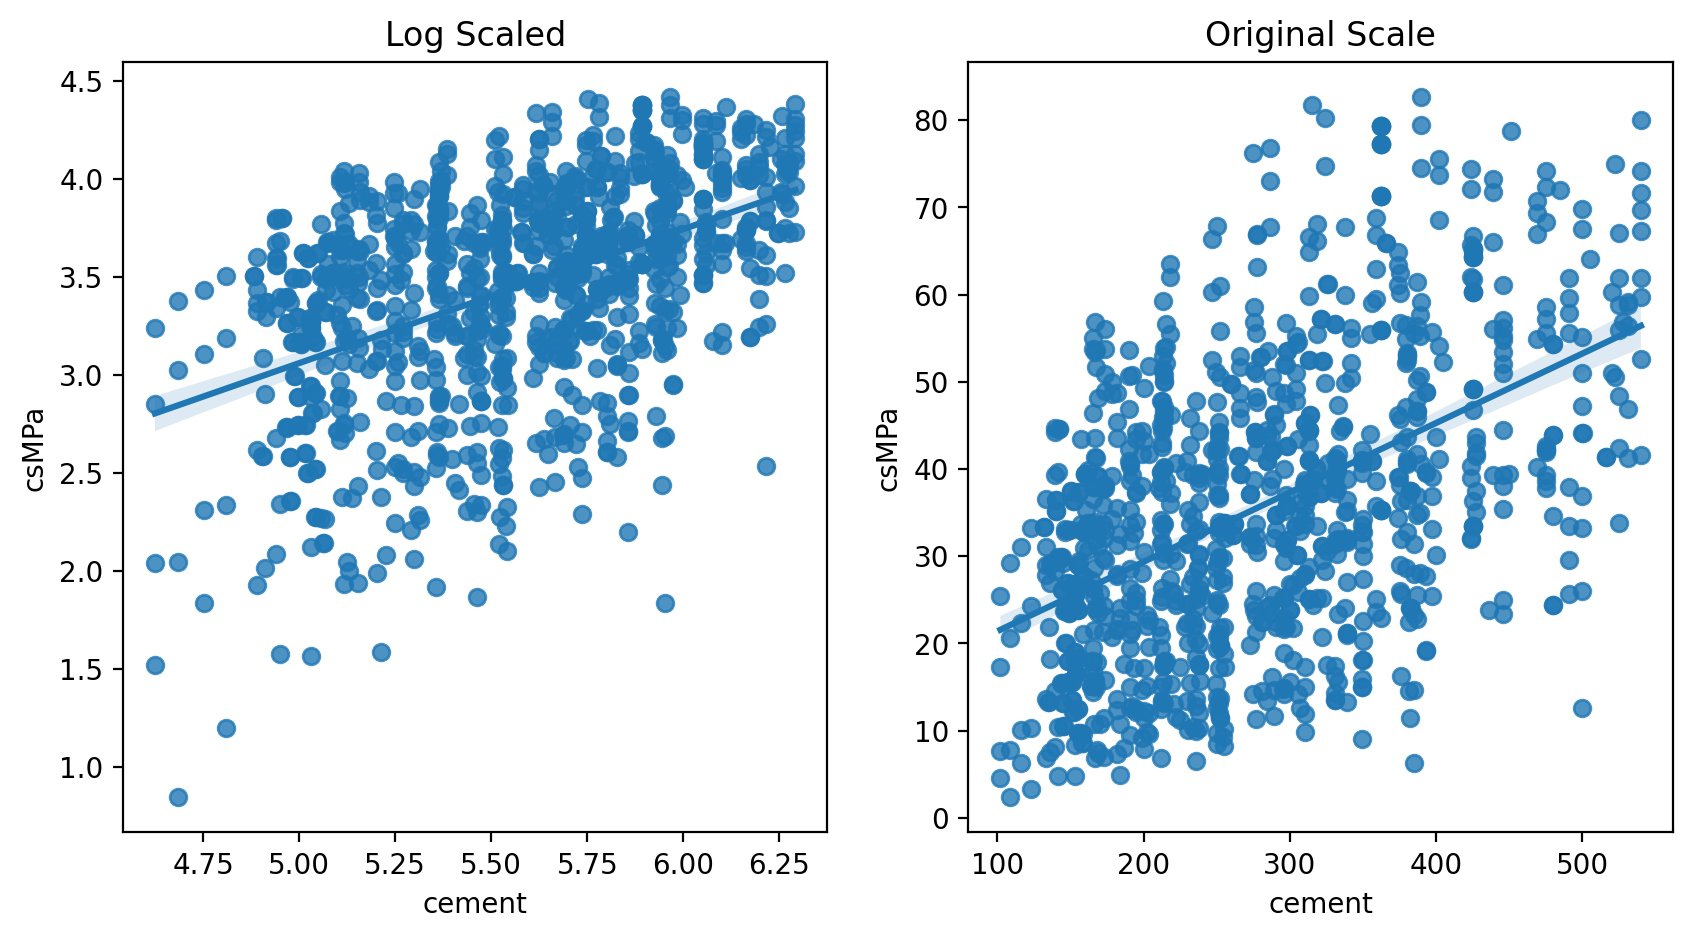

In [13]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
sns.regplot(x=np.log(data['cement']),y=np.log(data['csMPa']),ax=ax[0])
sns.regplot(x=data['cement'],y=data['csMPa'],ax=ax[1])


ax[0].set_title('Log Scaled')
ax[1].set_title('Original Scale')

So how to choose our prior ? 

From that we can see that the slope ranges from 1 to 2 , we can specify our model 


$$
\begin{align}
log(rides) & \sim Normal(\mu,\sigma) \text{ [likelihood]} \\
\mu &= \alpha + \beta *log(\text{cement}_i) \\ 
\alpha & \sim Normal(\mu = 2,\sigma =1) \text{ [prior]} \\
\beta & \sim Normal(\mu = 2,\sigma =1) \text{ [prior]} \\
\sigma & \sim Expon(\lambda = 2)\text{ [prior]} \\
\end{align}
$$


**Likelihood** 

We need to decide which likelihood we are using , we can check the `logcsmpa` distribution

<Axes: xlabel='log_csMPa', ylabel='Density'>

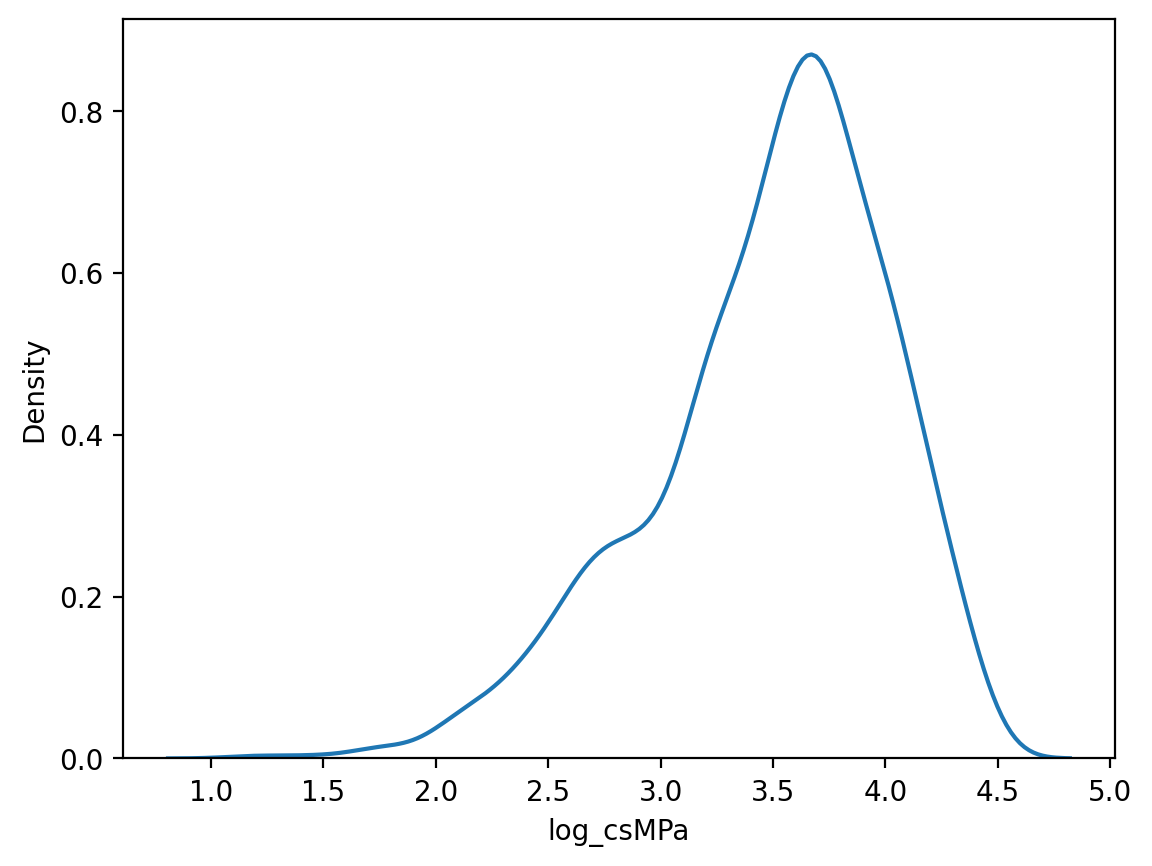

In [14]:
sns.kdeplot(data=data,x='log_csMPa')

we have tails on our data, or skewed data, okay we can check avalaible distribution in pymc 

**Skew Normal Distribution**

![skew normal](https://www.pymc.io/projects/docs/en/latest/_images/pymc-SkewNormal-1.png)

**Student T Distribution**

![Student T](https://www.pymc.io/projects/docs/en/latest/_images/pymc-StudentT-1.png)

In [15]:
with pm.Model() as strenght_model1 :
#
    a = pm.Normal('a', mu=0, sigma=10)
    b = pm.Normal('b', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Convert data to PyMC3 tensor
    log_cement_tensor = pm.Data("log_cement_tensor", data['log_cement'], mutable=False)

    # Define the linear model
    linear_model = a + b * log_cement_tensor
    
    # Likelihood
    likelihood = pm.Normal('logcsmpa', mu=linear_model, sigma=sigma, observed=data['log_csMPa'].values)


### 4. Prior Predictive Checking


Next, let's measure how our prior prediction looks like. 
Some steps 



In [16]:
with strenght_model1 :
      strenght_model1_prior = pm.sample_prior_predictive(100)

Sampling: [a, b, logcsmpa, sigma]


Text(0.5, 1.0, 'Prior Prediction Plot using Original scale')

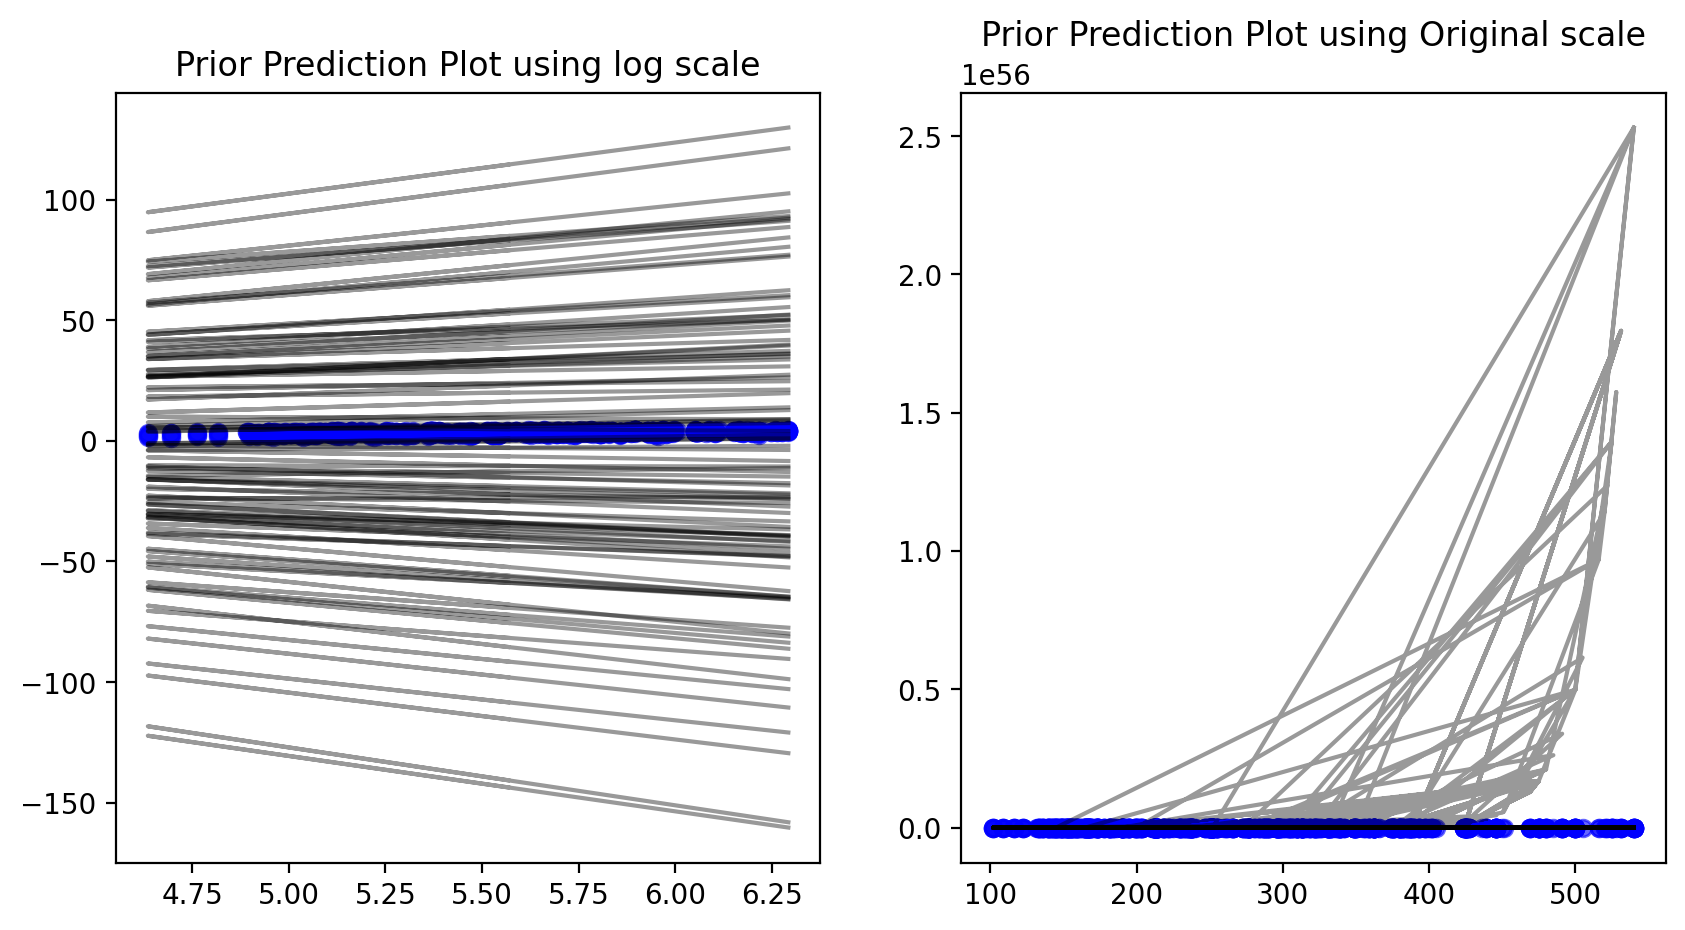

In [17]:
shape_prior_samples = strenght_model1_prior.prior['a'].values.flatten().shape[0]
n_data = data.shape[0] 
csmpa_pred = np.zeros(( n_data , shape_prior_samples ))



for i, val in enumerate(data['log_cement']):
    # dont forget to inverse 
    csmpa_pred[i] = strenght_model1_prior.prior["a"] + strenght_model1_prior.prior["b"]  * val

inverse_scaled_csmpa = np.exp(csmpa_pred)

fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
for i in range(shape_prior_samples) : 
    ax[0].plot(data['log_cement'],csmpa_pred[:,i], c="k", alpha=0.4)

ax[0].scatter(data['log_cement'],data['log_csMPa'], c="blue", alpha=0.6)
ax[0].set_title('Prior Prediction Plot using log scale')



for i in range(shape_prior_samples) : 
    ax[1].plot(data['cement'],inverse_scaled_csmpa[:,i], c="k", alpha=0.4)

ax[1].scatter(data['cement'],data['csMPa'], c="blue", alpha=0.6)
ax[1].set_title('Prior Prediction Plot using Original scale')

Our prior still have some limitation, which there is some sample of data that are far from our observed data

## Fitting Model

Now its time to fit our model --> it means sampling from posterior


#### Adding Random Number Generator

Before we start fitting our we need to setup what is called as **random number** generator like random_state in scikit-learn. Why ? 

Because we want each time we run the model, the result is pretty consistent


The key is **reproducibility** 

In [18]:
RANDOM_SEED = 42

In [19]:
with strenght_model1 :
  strenght_model1_trace = pm.sample(2000, random_seed=RANDOM_SEED, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 21 seconds.


### 5. Checking Model Inference Process


One of the core powerful tool that can estimate posterior distribution is our sampling algorithm. 


The Inference / Posterior Sampling Process is not simply like `model.fit()` . 

Our MCMC algorithm may lead to suboptimal result. Hence it's important to check whether our sampling / trace works properly. 


So what is the definition of proper? 

To check whether during there is / are problem when fitting the model we can check the trace of each sample generated for our parameters

To do so , we can use `arviz.plot_trace` 

#### Plotting Trace

array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

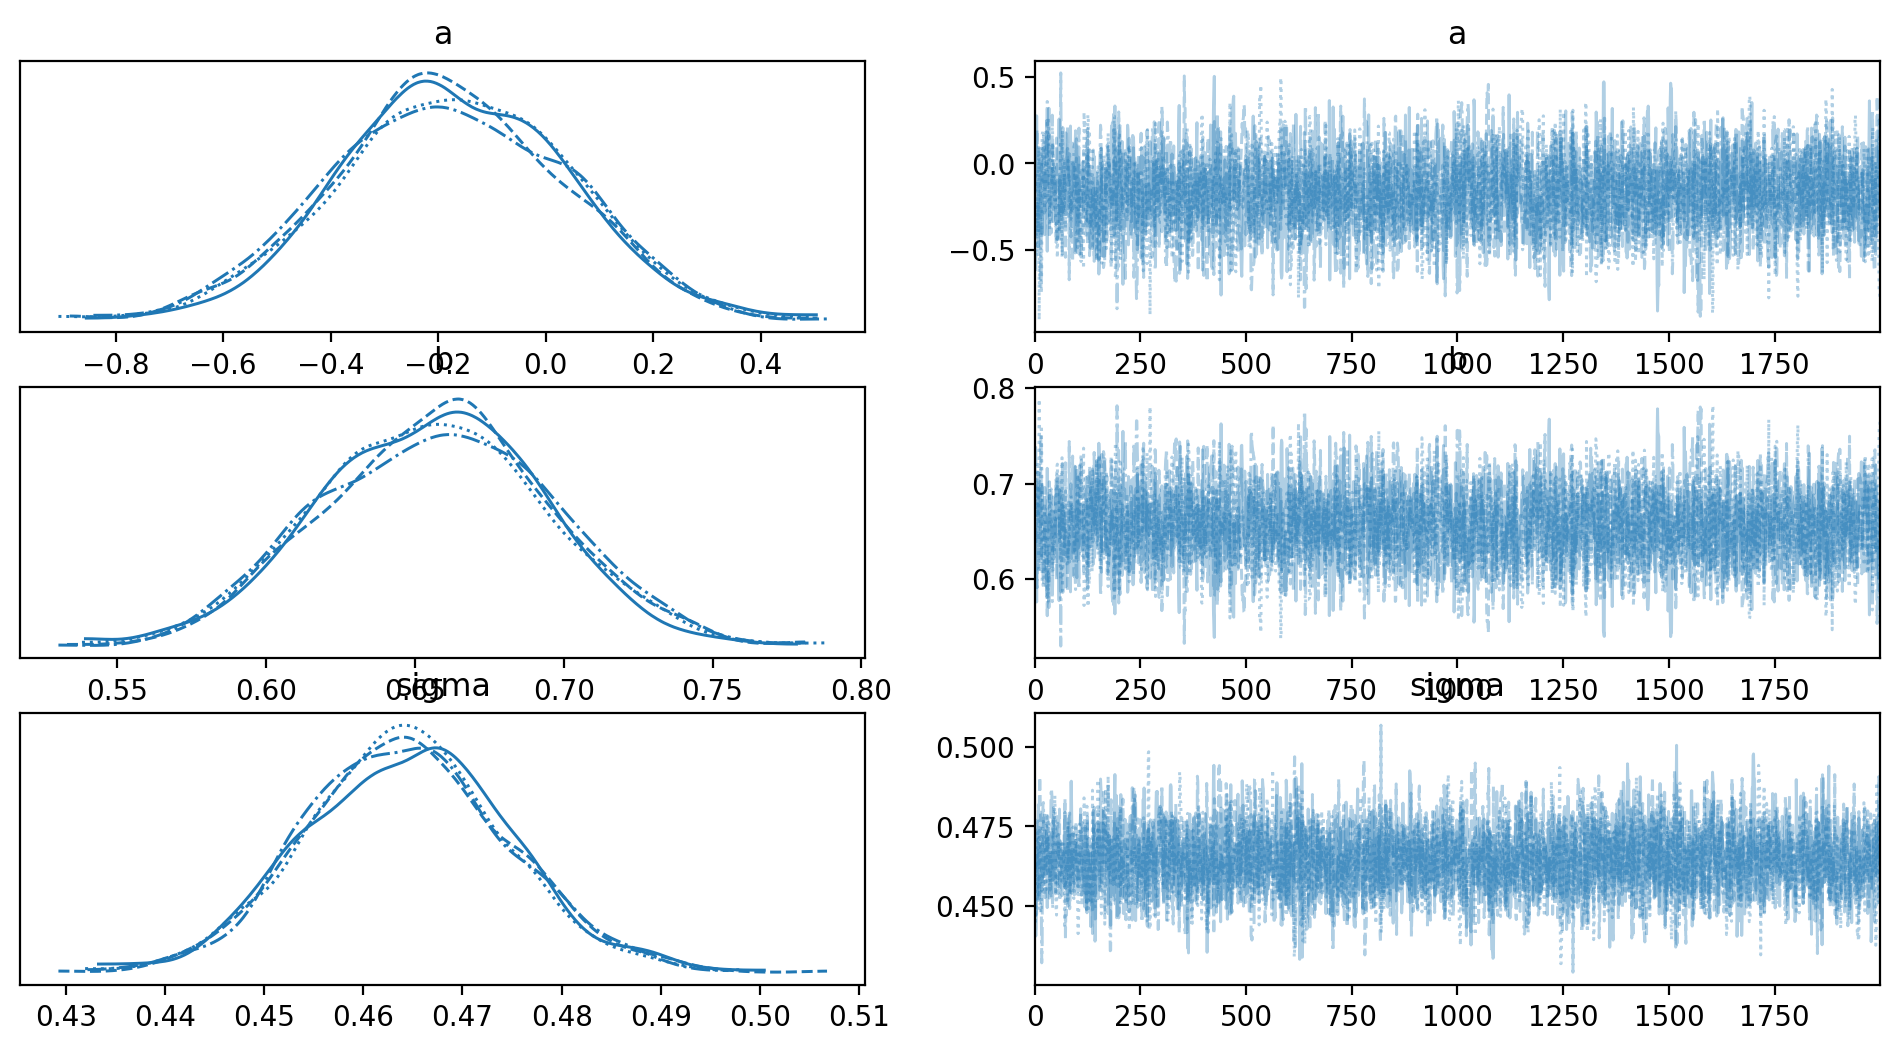

In [20]:
az.plot_trace(strenght_model1_trace, var_names=('a','b','sigma'))

So what is it ? 

**Left Figure** : Density of our posterior, if you see there is multiple lines , it comes from chain in pymc, chain term it self refer to independent sampling process 

**Right Figure** : The changes from our parameter values, during posterior sampling process 



From our result you might curious is it bad or good ? 

**Good Definition** : During posterior sampling , our parameter value converge towards some value, here we can see for example $\alpha$ converge towards zero, or not increase / decrease too exterme 




The next thing we could check about our sampling process is that we can checks it autocorrelation

To check autocorrelation we can use `arviz.plot_autocorr(<trace>)`

array([[<Axes: title={'center': 'a\n0'}>,
        <Axes: title={'center': 'a\n1'}>,
        <Axes: title={'center': 'a\n2'}>],
       [<Axes: title={'center': 'a\n3'}>,
        <Axes: title={'center': 'b\n0'}>,
        <Axes: title={'center': 'b\n1'}>],
       [<Axes: title={'center': 'b\n2'}>,
        <Axes: title={'center': 'b\n3'}>,
        <Axes: title={'center': 'sigma\n0'}>],
       [<Axes: title={'center': 'sigma\n1'}>,
        <Axes: title={'center': 'sigma\n2'}>,
        <Axes: title={'center': 'sigma\n3'}>]], dtype=object)

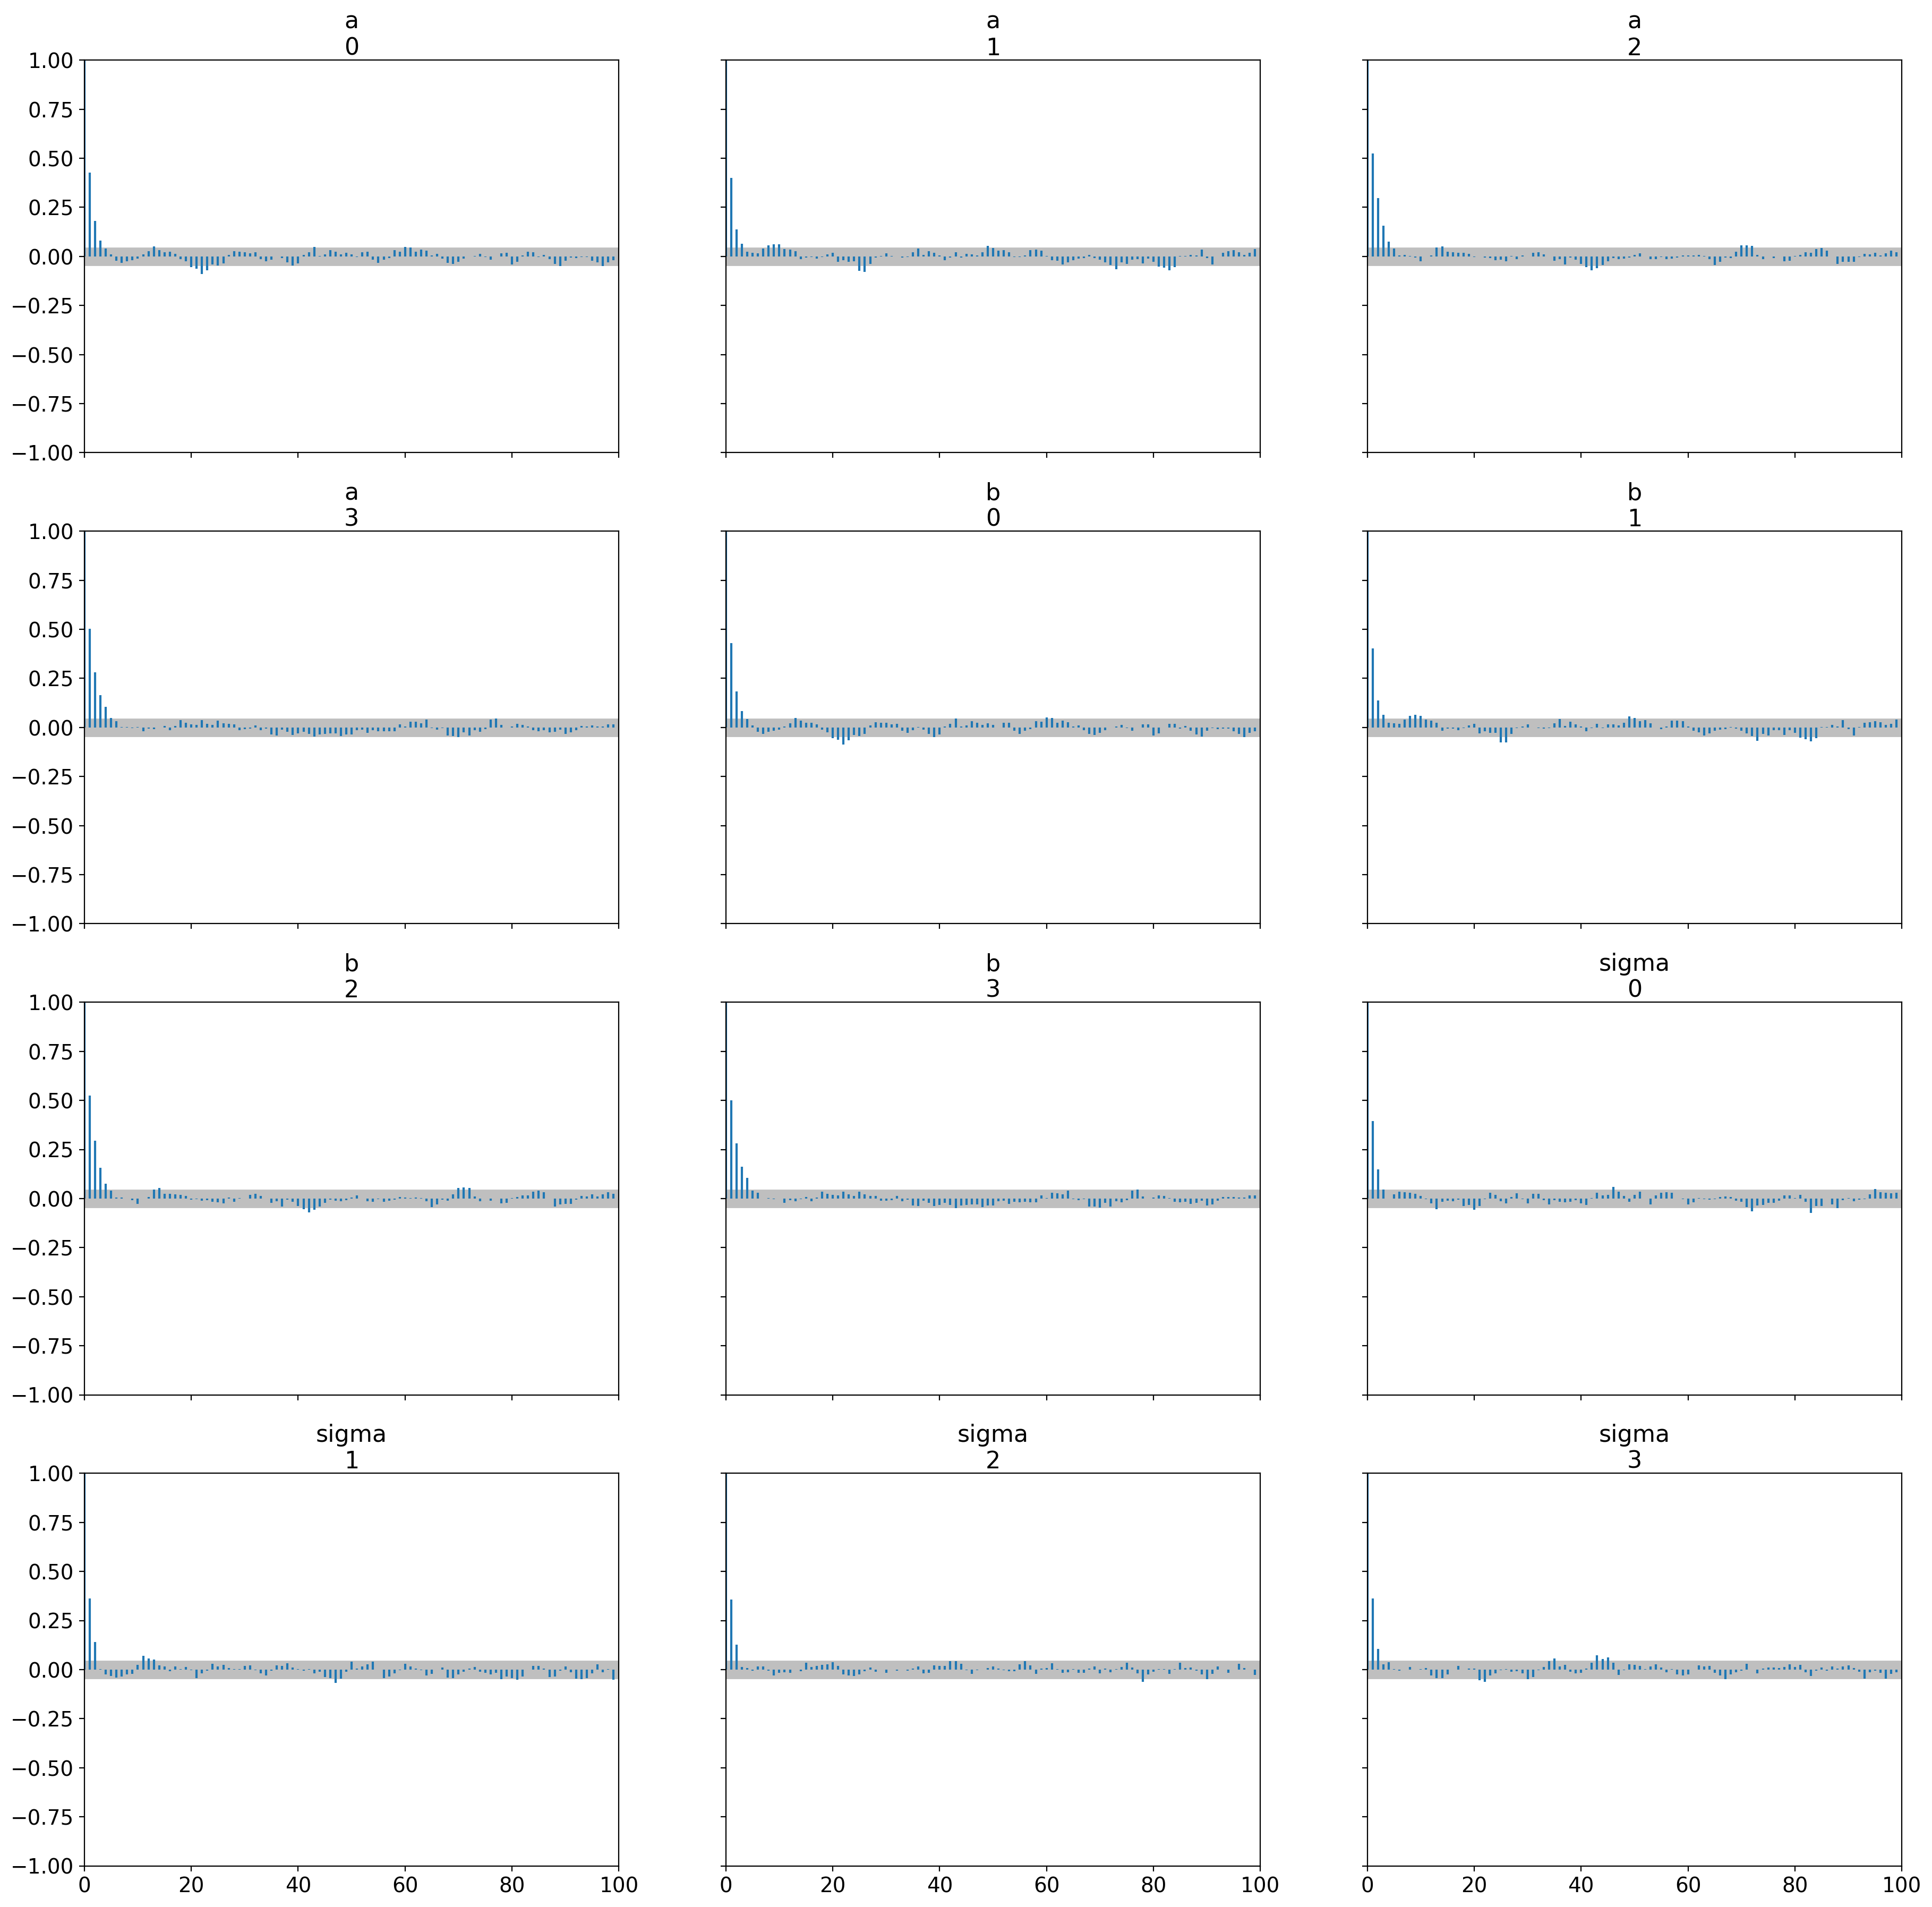

In [21]:
az.plot_autocorr(strenght_model1_trace,var_names=['a','b','sigma'])

**Good/Ideal Condition** : 

During finding the posterior, we start from initial values, if for example in the next iteration we stuck in the same value over and over again making we never reach optimal posterior, hence good when , autocorrelation are low

#### Summarizing Model Output

Since your bayesian model return distribution from posterior , it has many range of values 

In [22]:
az.summary(strenght_model1_trace,var_names=['a','b','sigma'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a     -0.175  0.213  -0.571    0.218      0.004    0.003    2678.0    3040.0   
b      0.657  0.038   0.585    0.727      0.001    0.001    2694.0    3071.0   
sigma  0.464  0.010   0.445    0.483      0.000    0.000    3887.0    3559.0   

       r_hat  
a        1.0  
b        1.0  
sigma    1.0

For now, you can focus on some of them 

1. `mean` : mean of parameter
2. `sd` : standard dev of parameter
3. `hdi_` : confidence interval
the rest you don't need to know it for now, its part of detail of MCMC algorithm, we will learn the `MCMC` detail in Chapter 9 to 10. 

We can also plot the posterior from our parameters

array([<Axes: title={'center': 'a'}>, <Axes: title={'center': 'b'}>,
       <Axes: title={'center': 'sigma'}>], dtype=object)

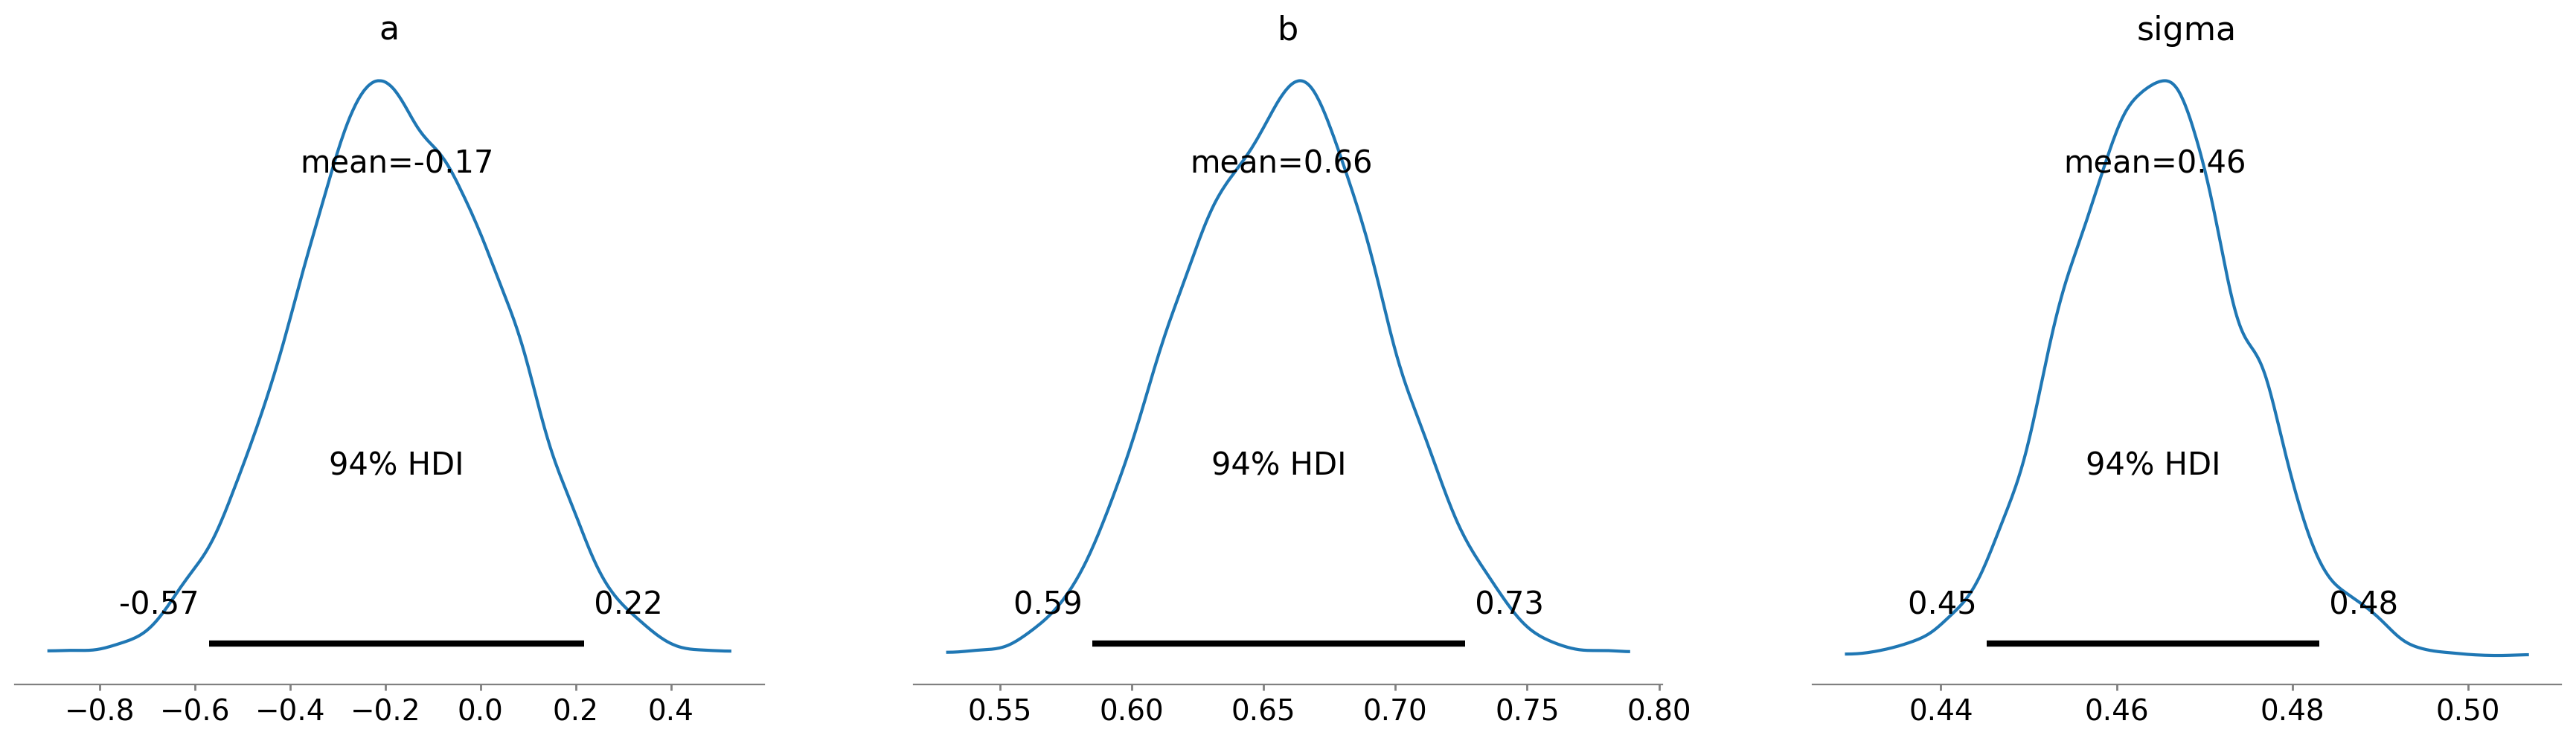

In [23]:
az.plot_posterior(strenght_model1_trace,var_names=['a','b','sigma'])

Our coefficient is in log scale

we could interpret interms of original scales 




Text(0.5, 1.0, 'exp from sigma posterior')

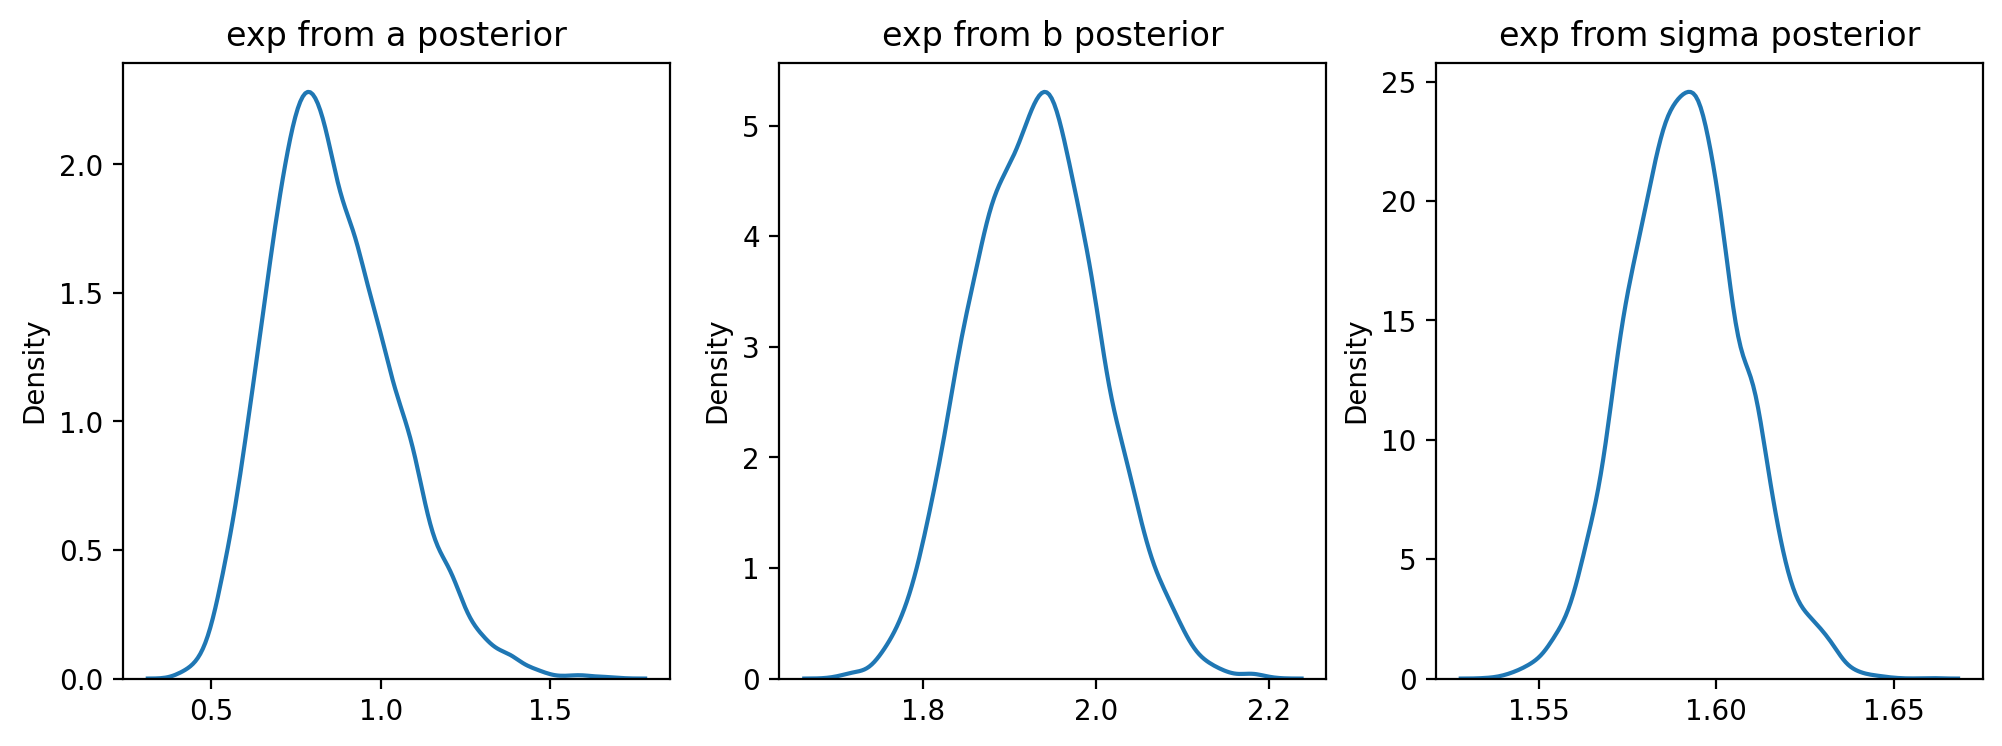

In [24]:
figure_post,ax = plt.subplots(nrows=1,ncols=3,figsize=(12,4))
exp_a = np.exp(strenght_model1_trace.posterior['a'].values.flatten())
exp_b = np.exp(strenght_model1_trace.posterior['b'].values.flatten())
exp_sigma = np.exp(strenght_model1_trace.posterior['sigma'].values.flatten())
sns.kdeplot(exp_a,ax=ax[0])
sns.kdeplot(exp_b,ax=ax[1])
sns.kdeplot(exp_sigma,ax=ax[2])

ax[0].set_title('exp from a posterior')
ax[1].set_title('exp from b posterior')
ax[2].set_title('exp from sigma posterior')

## Constructing Data Based on Model Fit (Posterior) 


The basic idea is to check whether our procedure recovers the correct parameter values when fitting fake data. 


The procedure is to simulate some fake data from the model with fixed, known parameters and then see whether our method comes close to reproducing the known truth. 

We can look at point estimates and also the coverage of posterior intervals.


### Fitting Model using Fake Data

Generate fake data first 

In [25]:
# Generate cement
cement = np.linspace(3, 5, 500)

# Generate demands based on the model
intercept = 0.5
beta_cement = 1.5
sigma = np.random.normal(0, 0.5, size=cement.shape)
csmpa = intercept + beta_cement * cement 

# Create a DataFrame
fake_strenght = pd.DataFrame({'log_cement': cement, 'log_csMPa': csmpa})

In [26]:
with pm.Model() as fake_data_model :
#
  a = pm.Normal('a',0,0.5)
  b = pm.Normal('b',0,1)
  sigma = pm.Exponential('sigma',0.5)

  # likelihood

  linear_model = pm.Deterministic('mu',a + b * fake_strenght['log_cement'].values)
  likelihood = pm.Normal('log_csMPa',mu=linear_model,sigma=sigma,observed=fake_strenght['log_csMPa'].values)


Let's fit the model 


In [27]:
with fake_data_model : 
    fake_model_trace = pm.sample(1000,random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 93 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 837 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


Now, let's summary the posterior 

In [28]:
az.summary(fake_model_trace,var_names=['a','b','sigma'])

mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a       0.5  0.0     0.5      0.5        0.0      0.0    1018.0      70.0   
b       1.5  0.0     1.5      1.5        0.0      0.0    1009.0      48.0   
sigma   0.0  0.0     0.0      0.0        0.0      0.0       5.0      12.0   

       r_hat  
a       1.17  
b       1.17  
sigma   3.14

now its time to compare the true parameter and fitted parameter 

Actual Parameter 

1. intercept = 0.5
2. cement_temp = 1.5
3. sigma = np.random.normal(0, 0.5,cementatures.shape)

Our Fitted Model Posterior 

1. intercet2= 0.348cement. beta_tem3 = 1.538 
3. sigma     = 0.499 



So what is considered as good ? 

- Good when there is small discrepancy between the fitted parameters vs true parameter

## Evaluating Model

The next step is we need to evaluate whether our model working properly 


### 6. Posterior Predictive Check 

We can do some check based on our model fit, we can simulate dataset from our posterior. First we can sample our posterior from our parameter


In [29]:
with strenght_model1 :
    strenght_model1_ppc = pm.sample_posterior_predictive(strenght_model1_trace,var_names=['logcsmpa'],
                                                       random_seed=RANDOM_SEED)


Sampling: [logcsmpa]


In [30]:
logcsmpa_simulated = strenght_model1_ppc['posterior_predictive']['logcsmpa'].values
chain,draw,n_posterior_draw = logcsmpa_simulated.shape
logcsmpa_simulated = logcsmpa_simulated.reshape(chain*draw,n_posterior_draw)

In [33]:
data

cement   slag  flyash  water  superplasticizer  coarseaggregate  \
0      540.0    0.0     0.0  162.0               2.5           1040.0   
1      540.0    0.0     0.0  162.0               2.5           1055.0   
2      332.5  142.5     0.0  228.0               0.0            932.0   
3      332.5  142.5     0.0  228.0               0.0            932.0   
4      198.6  132.4     0.0  192.0               0.0            978.4   
...      ...    ...     ...    ...               ...              ...   
1025   276.4  116.0    90.3  179.6               8.9            870.1   
1026   322.2    0.0   115.6  196.0              10.4            817.9   
1027   148.5  139.4   108.6  192.7               6.1            892.4   
1028   159.1  186.7     0.0  175.6              11.3            989.6   
1029   260.9  100.5    78.3  200.6               8.6            864.5   

      fineaggregate  age  csMPa  log_csMPa  log_cement  
0             676.0   28  79.99   4.394326    6.293419  
1             676.0   28  61.89   4.141387    6.293419  
2             594.0  270  40.27   3.720136    5.809643  
3             594.0  365  41.05   3.738859    5.809643  
4             825.5  360  44.30   3.813307    5.296315  
...             ...  ...    ...        ...         ...  
1025          768.3   28  44.28   3.812865    5.625461  
1026          813.4   28  31.18   3.471345    5.778271  
1027          780.0   28  23.70   3.206803    5.007296  
1028          788.9   28  32.77   3.519573    5.075799  
1029          761.5   28  32.40   3.508556    5.567963  

[1030 rows x 11 columns]

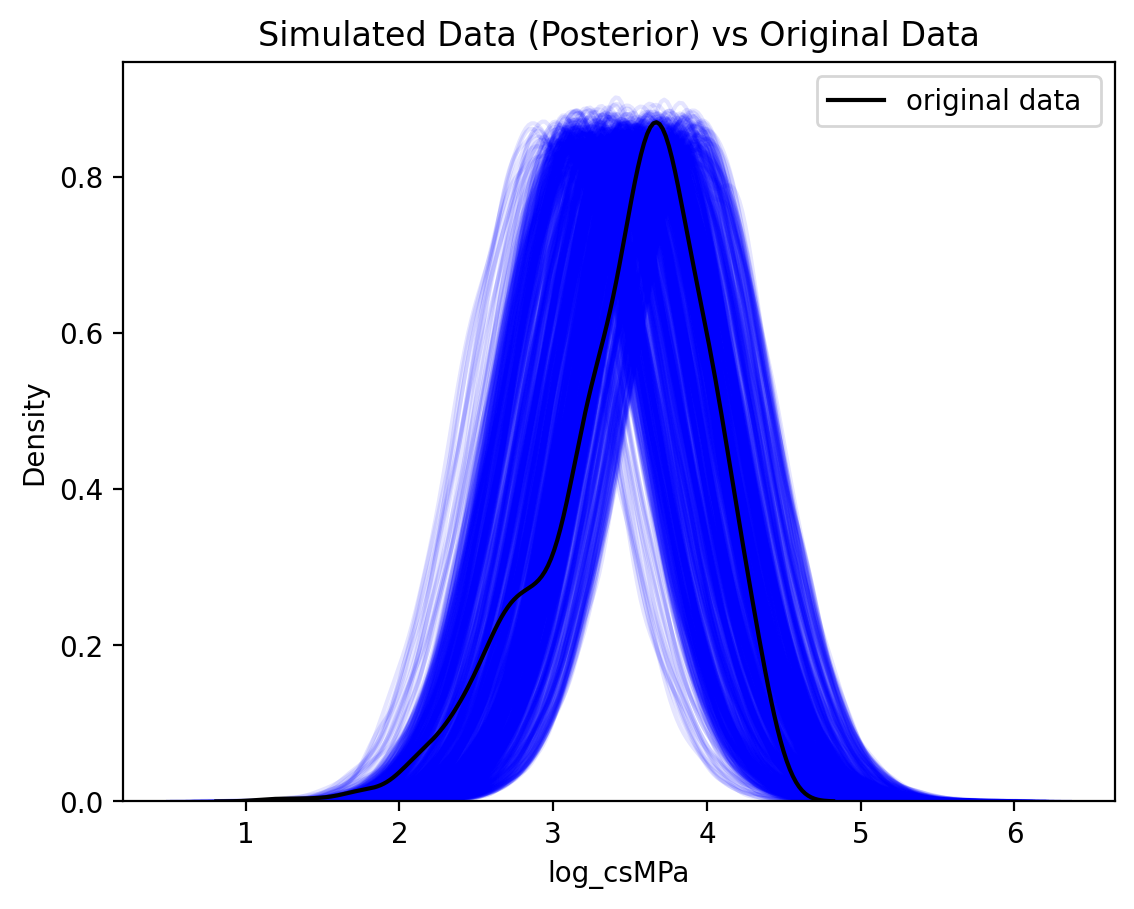

In [34]:
fig,ax = plt.subplots()
for idx in range(logcsmpa_simulated.shape[1]) : 
    sns.kdeplot(logcsmpa_simulated[:,idx],alpha=0.1,color='blue')
sns.kdeplot(data['log_csMPa'],label='original data ',color='black')
plt.title('Simulated Data (Posterior) vs Original Data')
plt.legend()

Or you can use `az.plot_ppc`

<Axes: xlabel='logcsmpa / logcsmpa'>

/home/devteam/datascience/learnings/customer_risk_probability_of_default/.venv/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/devteam/datascience/learnings/customer_risk_probability_of_default/.venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


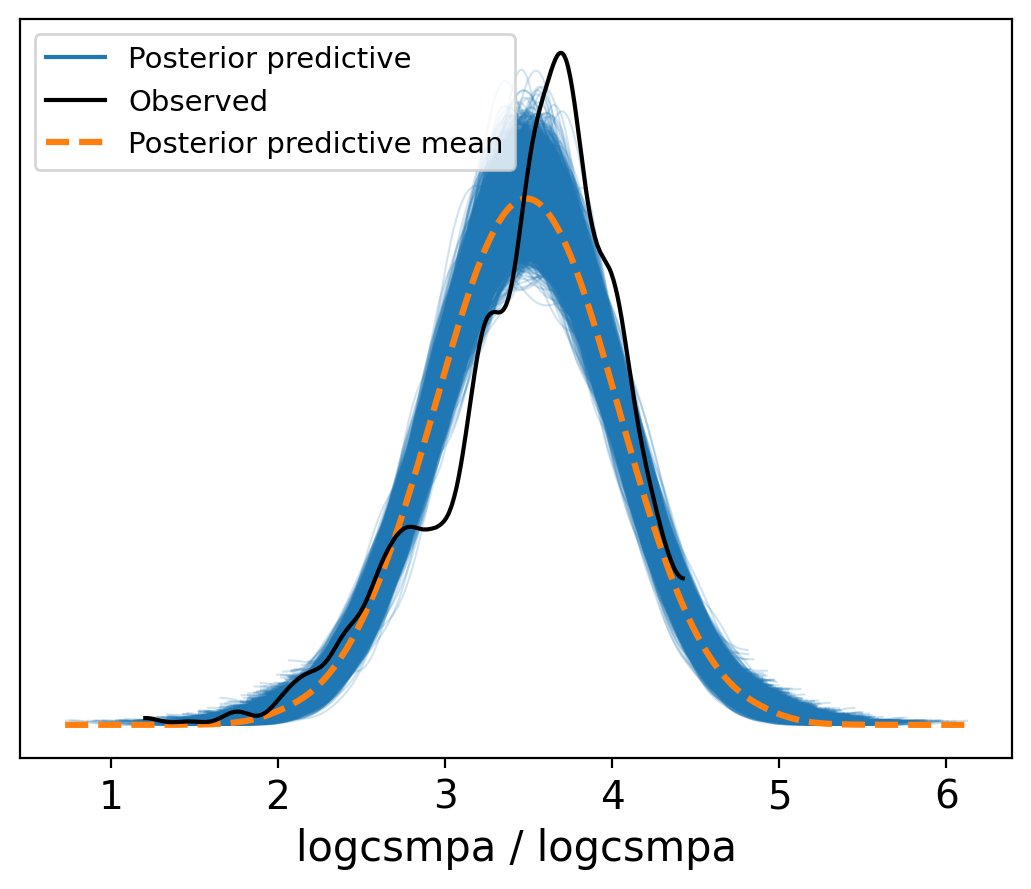

In [35]:
az.plot_ppc(strenght_model1_ppc,var_names=['logcsmpa'],observed=True)

As we can see, our model still have some limitation based on synthetic or generated data, where it did not have long tail on left side, so what is our alternative here ? 

The key is **Better at capturing tails**

Our models using simulated data and show its posterior, is quite weird, there are several reson for this 

- we use simulated data by taking its mean


### 7. Cross Validation 

Cross Validation term in machine learning is quite good example to measure model fit, instead of predicting test set directly we can use average metrics from the cross validation , why ? because if we predict test set only there is tendency that the metrics is overestimated


The detailed process of cross validation is in the next chapter

## Understanding and Comparing Multiple Model

### Comparing Model
When we try to build the model, we should carefully build it from small model, iterate to more complex model, we can also compare the model in terms of prediction value ranges

Here we will try to simulate different models ranging from simple models to complex model 

In [36]:
data

cement   slag  flyash  water  superplasticizer  coarseaggregate  \
0      540.0    0.0     0.0  162.0               2.5           1040.0   
1      540.0    0.0     0.0  162.0               2.5           1055.0   
2      332.5  142.5     0.0  228.0               0.0            932.0   
3      332.5  142.5     0.0  228.0               0.0            932.0   
4      198.6  132.4     0.0  192.0               0.0            978.4   
...      ...    ...     ...    ...               ...              ...   
1025   276.4  116.0    90.3  179.6               8.9            870.1   
1026   322.2    0.0   115.6  196.0              10.4            817.9   
1027   148.5  139.4   108.6  192.7               6.1            892.4   
1028   159.1  186.7     0.0  175.6              11.3            989.6   
1029   260.9  100.5    78.3  200.6               8.6            864.5   

      fineaggregate  age  csMPa  log_csMPa  log_cement  
0             676.0   28  79.99   4.394326    6.293419  
1             676.0   28  61.89   4.141387    6.293419  
2             594.0  270  40.27   3.720136    5.809643  
3             594.0  365  41.05   3.738859    5.809643  
4             825.5  360  44.30   3.813307    5.296315  
...             ...  ...    ...        ...         ...  
1025          768.3   28  44.28   3.812865    5.625461  
1026          813.4   28  31.18   3.471345    5.778271  
1027          780.0   28  23.70   3.206803    5.007296  
1028          788.9   28  32.77   3.519573    5.075799  
1029          761.5   28  32.40   3.508556    5.567963  

[1030 rows x 11 columns]

In [37]:
# single var model 
with pm.Model() as model1 :
#
    a = pm.Normal('a',0,0.5)
    b = pm.Normal('b',0,1)
    sigma = pm.Exponential('sigma',0.5)

    # likelihood

    linear_model = pm.Deterministic('mu',a + b * data['log_cement'].astype(np.float64).values)
    likelihood = pm.Normal('logcsmpa',mu=linear_model,sigma=sigma,observed=data['log_csMPa'].astype(np.float64).values)

    # sample posterior
    model1_trace = pm.sample(1000,random_seed=RANDOM_SEED)
    



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


In [38]:
data['log_slag'] = np.log(data['slag'].replace(0, 1e-6))
data['log_flyash'] = np.log(data['flyash'].replace(0, 1e-6))
data['log_water'] = np.log(data['water'].replace(0, 1e-6))
data['log_superplasticizer'] = np.log(data['superplasticizer'].replace(0, 1e-6))
data['log_coarseaggregate'] = np.log(data['coarseaggregate'].replace(0, 1e-6))
data['log_fineaggregate'] = np.log(data['fineaggregate'].replace(0, 1e-6))
data['log_age'] = np.log(data['age'].replace(0, 1e-6))

In [39]:
# two var model , add log windspeed
with pm.Model() as model2 :
#
    a = pm.Normal('a',0,0.5)
    b_cement = pm.Normal('b_cement',0,1)
    b_slag = pm.Normal('b_slag',0,1)
    sigma = pm.Exponential('sigma',0.5)

    # likelihood

    linear_model = pm.Deterministic('mu',a + b_cement * data['log_cement'].astype(np.float64).values  + b_slag * data['log_slag'].astype(np.float64).values)
    likelihood = pm.Normal('logcsmpa',mu=linear_model,sigma=sigma,observed=data['log_csMPa'].values)

    # sample posterior
    model2_trace = pm.sample(1000,random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b_temp, b_slag, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


In [42]:
# three var model , add flyash
with pm.Model() as model3 :
#
  a = pm.Normal('a',0,0.5)
  b_cement = pm.Normal('b_cement',0,1)
  b_slag = pm.Normal('b_slag',0,1)
  b_flyash = pm.Normal('b_flyash',0,1)
  sigma = pm.Exponential('sigma',0.5)

  # likelihood

  linear_model = pm.Deterministic('mu',a + b_cement * data['log_cement'].astype(np.float64).values \
                                  + b_slag * data['log_slag'].astype(np.float64).values \
                                  + b_flyash* data['log_flyash'].astype(np.float64).values)
  likelihood = pm.Normal('logcsmpa',mu=linear_model,sigma=sigma,observed=data['log_csMPa'].values)

  # sample posterior
  model3_trace = pm.sample(1000,random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b_cement, b_slag, b_flyash, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


In [43]:
# 4 var model , add water
with pm.Model() as model4 :
#
  a = pm.Normal('a',0,0.5)
  b_cement = pm.Normal('b_cement',0,1)
  b_slag = pm.Normal('b_slag',0,1)
  b_flyash = pm.Normal('b_flyash',0,1)
  b_water = pm.Normal('b_water',0,1)
  sigma = pm.Exponential('sigma',0.5)

  # likelihood

  linear_model = pm.Deterministic('mu',a + b_cement * data['log_cement'].astype(np.float64).values \
                                  + b_slag * data['log_slag'].astype(np.float64).values \
                                  + b_flyash* data['log_flyash'].astype(np.float64).values \
                                  + b_water* data['log_water'].astype(np.float64).values
                                )
  likelihood = pm.Normal('logcsmpa',mu=linear_model,sigma=sigma,observed=data['log_csMPa'].values)

  # sample posterior
  model4_trace = pm.sample(1000,random_seed=RANDOM_SEED)
    



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b_cement, b_slag, b_flyash, b_water, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 55 seconds.


In [44]:
data.columns

Index(['cement', 'slag', 'flyash', 'water', 'superplasticizer',
       'coarseaggregate', 'fineaggregate', 'age', 'csMPa', 'log_csMPa',
       'log_cement', 'log_slag', 'log_flyash', 'log_water',
       'log_superplasticizer', 'log_coarseaggregate', 'log_fineaggregate',
       'log_age'],
      dtype='object')

In [46]:
# 4 var model , add b_superplasticizer
with pm.Model() as model5 :
#
  a = pm.Normal('a',0,0.5)
  b_cement = pm.Normal('b_cement',0,1)
  b_slag = pm.Normal('b_slag',0,1)
  b_flyash = pm.Normal('b_flyash',0,1)
  b_water = pm.Normal('b_water',0,1)
  b_superplasticizer = pm.Normal('b_superplasticizer',0,1)
  sigma = pm.Exponential('sigma',0.5)

  # likelihood

  linear_model = pm.Deterministic('mu',a + b_cement * data['log_cement'].astype(np.float64).values \
                                  + b_slag * data['log_slag'].astype(np.float64).values \
                                  + b_flyash* data['log_flyash'].astype(np.float64).values \
                                  + b_water* data['log_water'].astype(np.float64).values
                                  + b_superplasticizer* data['log_superplasticizer'].astype(np.float64).values
                                )
  likelihood = pm.Normal('logcsmpa',mu=linear_model,sigma=sigma,observed=data['log_csMPa'].values)

  # sample posterior
  model5_trace = pm.sample(1000,random_seed=RANDOM_SEED)
    



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b_cement, b_slag, b_flyash, b_water, b_superplasticizer, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.


In [47]:
# 4 var model , add b_superplasticizer
with pm.Model() as model6 :
#
  a = pm.Normal('a',0,0.5)
  b_cement = pm.Normal('b_cement',0,1)
  b_slag = pm.Normal('b_slag',0,1)
  b_flyash = pm.Normal('b_flyash',0,1)
  b_water = pm.Normal('b_water',0,1)
  b_superplasticizer = pm.Normal('b_superplasticizer',0,1)
  b_coarseaggregate = pm.Normal('b_coarseaggregate',0,1)
  sigma = pm.Exponential('sigma',0.5)

  # likelihood

  linear_model = pm.Deterministic('mu',a + b_cement * data['log_cement'].astype(np.float64).values \
                                  + b_slag * data['log_slag'].astype(np.float64).values \
                                  + b_flyash* data['log_flyash'].astype(np.float64).values \
                                  + b_water* data['log_water'].astype(np.float64).values \
                                  + b_superplasticizer* data['log_superplasticizer'].astype(np.float64).values \
                                  + b_coarseaggregate* data['log_coarseaggregate'].astype(np.float64).values
                                )
  likelihood = pm.Normal('logcsmpa',mu=linear_model,sigma=sigma,observed=data['log_csMPa'].values)

  # sample posterior
  model6_trace = pm.sample(1000,random_seed=RANDOM_SEED)
    



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b_cement, b_slag, b_flyash, b_water, b_superplasticizer, b_coarseaggregate, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 109 seconds.


In [48]:
# 4 var model , add b_superplasticizer
with pm.Model() as model7 :
#
  a = pm.Normal('a',0,0.5)
  b_cement = pm.Normal('b_cement',0,1)
  b_slag = pm.Normal('b_slag',0,1)
  b_flyash = pm.Normal('b_flyash',0,1)
  b_water = pm.Normal('b_water',0,1)
  b_superplasticizer = pm.Normal('b_superplasticizer',0,1)
  b_coarseaggregate = pm.Normal('b_coarseaggregate',0,1)
  b_fineaggregate = pm.Normal('b_fineaggregate',0,1)
  sigma = pm.Exponential('sigma',0.5)

  # likelihood

  linear_model = pm.Deterministic('mu',a + b_cement * data['log_cement'].astype(np.float64).values \
                                  + b_slag * data['log_slag'].astype(np.float64).values \
                                  + b_flyash* data['log_flyash'].astype(np.float64).values \
                                  + b_water* data['log_water'].astype(np.float64).values \
                                  + b_superplasticizer* data['log_superplasticizer'].astype(np.float64).values \
                                  + b_coarseaggregate* data['log_coarseaggregate'].astype(np.float64).values
                                  + b_fineaggregate* data['log_fineaggregate'].astype(np.float64).values
                                )
  likelihood = pm.Normal('logcsmpa',mu=linear_model,sigma=sigma,observed=data['log_csMPa'].values)

  # sample posterior
  model7_trace = pm.sample(1000,random_seed=RANDOM_SEED)
    



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b_cement, b_slag, b_flyash, b_water, b_superplasticizer, b_coarseaggregate, b_fineaggregate, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 152 seconds.


In [49]:
# 4 var model , add b_superplasticizer
with pm.Model() as model8 :
#
  a = pm.Normal('a',0,0.5)
  b_cement = pm.Normal('b_cement',0,1)
  b_slag = pm.Normal('b_slag',0,1)
  b_flyash = pm.Normal('b_flyash',0,1)
  b_water = pm.Normal('b_water',0,1)
  b_superplasticizer = pm.Normal('b_superplasticizer',0,1)
  b_coarseaggregate = pm.Normal('b_coarseaggregate',0,1)
  b_fineaggregate = pm.Normal('b_fineaggregate',0,1)
  b_age = pm.Normal('b_age',0,1)
  sigma = pm.Exponential('sigma',0.5)

  # likelihood

  linear_model = pm.Deterministic('mu',a + b_cement * data['log_cement'].astype(np.float64).values \
                                  + b_slag * data['log_slag'].astype(np.float64).values \
                                  + b_flyash* data['log_flyash'].astype(np.float64).values \
                                  + b_water* data['log_water'].astype(np.float64).values \
                                  + b_superplasticizer* data['log_superplasticizer'].astype(np.float64).values \
                                  + b_coarseaggregate* data['log_coarseaggregate'].astype(np.float64).values
                                  + b_age* data['log_age'].astype(np.float64).values
                                )
  likelihood = pm.Normal('logcsmpa',mu=linear_model,sigma=sigma,observed=data['log_csMPa'].values)

  # sample posterior
  model8_trace = pm.sample(1000,random_seed=RANDOM_SEED)
    



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b_cement, b_slag, b_flyash, b_water, b_superplasticizer, b_coarseaggregate, b_fineaggregate, b_age, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 147 seconds.


In [50]:
from IPython.display import display 

In [51]:
display(az.summary(model1_trace,var_names=["~mu"]))
display(az.summary(model2_trace,var_names=["~mu"]))
display(az.summary(model3_trace,var_names=["~mu"]))
display(az.summary(model4_trace,var_names=["~mu"]))
display(az.summary(model5_trace,var_names=["~mu"]))
display(az.summary(model6_trace,var_names=["~mu"]))
display(az.summary(model7_trace,var_names=["~mu"]))
display(az.summary(model8_trace,var_names=["~mu"]))

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a     -0.143  0.194  -0.523    0.205      0.005    0.004    1314.0    1368.0   
b      0.651  0.035   0.586    0.715      0.001    0.001    1308.0    1317.0   
sigma  0.464  0.010   0.446    0.485      0.000    0.000    1901.0    1588.0   

       r_hat  
a       1.00  
b       1.01  
sigma   1.00

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a      -0.480  0.187  -0.819   -0.121      0.005    0.003    1642.0    2102.0   
b_temp  0.723  0.034   0.662    0.787      0.001    0.001    1639.0    2104.0   
b_slag  0.017  0.002   0.014    0.020      0.000    0.000    2820.0    2154.0   
sigma   0.439  0.010   0.421    0.456      0.000    0.000    2427.0    2328.0   

        r_hat  
a         1.0  
b_temp    1.0  
b_slag    1.0  
sigma     1.0

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
a        -0.996  0.184  -1.330   -0.640      0.004    0.003    1981.0   
b_cement  0.830  0.034   0.766    0.892      0.001    0.001    1954.0   
b_slag    0.019  0.001   0.017    0.022      0.000    0.000    3037.0   
b_flyash  0.013  0.002   0.011    0.016      0.000    0.000    2627.0   
sigma     0.423  0.009   0.405    0.439      0.000    0.000    3433.0   

          ess_tail  r_hat  
a           2221.0    1.0  
b_cement    2140.0    1.0  
b_slag      2789.0    1.0  
b_flyash    2574.0    1.0  
sigma       2460.0    1.0

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
a         0.894  0.408   0.156    1.675      0.009    0.006    2156.0   
b_cement  0.862  0.036   0.795    0.930      0.001    0.000    2765.0   
b_slag    0.019  0.001   0.017    0.022      0.000    0.000    3155.0   
b_flyash  0.012  0.002   0.009    0.015      0.000    0.000    2969.0   
b_water  -0.398  0.074  -0.536   -0.257      0.002    0.001    2358.0   
sigma     0.418  0.009   0.401    0.435      0.000    0.000    3947.0   

          ess_tail  r_hat  
a           2172.0    1.0  
b_cement    2571.0    1.0  
b_slag      2389.0    1.0  
b_flyash    2807.0    1.0  
b_water     2149.0    1.0  
sigma       2465.0    1.0

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
a                   0.206  0.421  -0.568    0.982      0.009    0.007   
b_cement            0.766  0.037   0.698    0.836      0.001    0.001   
b_slag              0.015  0.002   0.012    0.018      0.000    0.000   
b_flyash            0.001  0.002  -0.004    0.005      0.000    0.000   
b_water            -0.165  0.082  -0.323   -0.013      0.002    0.001   
b_superplasticizer  0.019  0.003   0.014    0.024      0.000    0.000   
sigma               0.408  0.009   0.392    0.425      0.000    0.000   

                    ess_bulk  ess_tail  r_hat  
a                     1985.0    2262.0   1.00  
b_cement              2492.0    2423.0   1.00  
b_slag                2578.0    2407.0   1.00  
b_flyash              2072.0    2562.0   1.00  
b_water               1861.0    2426.0   1.01  
b_superplasticizer    1843.0    2263.0   1.00  
sigma                 2886.0    2633.0   1.00

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
a                  -0.132  0.480  -1.039    0.748      0.010    0.007   
b_cement            0.757  0.037   0.688    0.828      0.001    0.001   
b_slag              0.015  0.002   0.012    0.018      0.000    0.000   
b_flyash            0.001  0.002  -0.003    0.005      0.000    0.000   
b_water            -0.255  0.102  -0.438   -0.057      0.002    0.002   
b_superplasticizer  0.019  0.003   0.013    0.023      0.000    0.000   
b_coarseaggregate   0.124  0.089  -0.036    0.293      0.002    0.001   
sigma               0.407  0.009   0.392    0.424      0.000    0.000   

                    ess_bulk  ess_tail  r_hat  
a                     2487.0    2532.0    1.0  
b_cement              2708.0    2922.0    1.0  
b_slag                2352.0    2678.0    1.0  
b_flyash              2094.0    2493.0    1.0  
b_water               2281.0    2034.0    1.0  
b_superplasticizer    1836.0    2531.0    1.0  
b_coarseaggregate     2058.0    2359.0    1.0  
sigma                 3195.0    2637.0    1.0

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
a                   0.263  0.494  -0.638    1.200      0.008    0.007   
b_cement            0.746  0.038   0.678    0.819      0.001    0.001   
b_slag              0.014  0.002   0.011    0.017      0.000    0.000   
b_flyash           -0.000  0.002  -0.004    0.004      0.000    0.000   
b_water            -0.188  0.103  -0.384   -0.005      0.002    0.002   
b_superplasticizer  0.021  0.003   0.016    0.027      0.000    0.000   
b_coarseaggregate   0.358  0.107   0.152    0.551      0.002    0.002   
b_fineaggregate    -0.344  0.094  -0.512   -0.163      0.002    0.001   
sigma               0.405  0.009   0.388    0.422      0.000    0.000   

                    ess_bulk  ess_tail  r_hat  
a                     3456.0    2697.0    1.0  
b_cement              2750.0    2558.0    1.0  
b_slag                2388.0    2374.0    1.0  
b_flyash              2000.0    2455.0    1.0  
b_water               2217.0    2428.0    1.0  
b_superplasticizer    1721.0    2077.0    1.0  
b_coarseaggregate     2200.0    2388.0    1.0  
b_fineaggregate       2364.0    2873.0    1.0  
sigma                 3849.0    2803.0    1.0

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
a                   0.067  0.448  -0.754    0.920      0.008    0.007   
b_cement            0.760  0.022   0.723    0.806      0.000    0.000   
b_slag              0.016  0.001   0.015    0.018      0.000    0.000   
b_flyash            0.002  0.001  -0.001    0.004      0.000    0.000   
b_water            -0.693  0.065  -0.812   -0.572      0.001    0.001   
b_superplasticizer  0.016  0.002   0.013    0.019      0.000    0.000   
b_coarseaggregate   0.295  0.064   0.182    0.420      0.001    0.001   
b_fineaggregate     0.012  1.013  -1.828    1.914      0.015    0.016   
b_age               0.279  0.006   0.267    0.291      0.000    0.000   
sigma               0.240  0.005   0.230    0.250      0.000    0.000   

                    ess_bulk  ess_tail  r_hat  
a                     2844.0    2596.0    1.0  
b_cement              3248.0    2570.0    1.0  
b_slag                3221.0    2701.0    1.0  
b_flyash              2636.0    3178.0    1.0  
b_water               3203.0    2718.0    1.0  
b_superplasticizer    2385.0    2856.0    1.0  
b_coarseaggregate     2787.0    2378.0    1.0  
b_fineaggregate       4586.0    2765.0    1.0  
b_age                 4802.0    2773.0    1.0  
sigma                 4670.0    2903.0    1.0

The value for cement remain the same as we increase model complexity 

Sample from posterior

In [52]:
with model1 : 
    #ppc 
    model_1_ppc = pm.sample_posterior_predictive(model1_trace,var_names=['logcsmpa'], random_seed=RANDOM_SEED)
    
with model2 : 
    #ppc 
    model_2_ppc = pm.sample_posterior_predictive(model2_trace,var_names=['logcsmpa'],random_seed=RANDOM_SEED)

with model3 : 
    #ppc 
    model_3_ppc = pm.sample_posterior_predictive(model3_trace,var_names=['logcsmpa'],random_seed=RANDOM_SEED)
    
with model4 : 
    #ppc 
    model_4_ppc = pm.sample_posterior_predictive(model4_trace,var_names=['logcsmpa'],random_seed=RANDOM_SEED)

with model5 : 
    #ppc 
    model_5_ppc = pm.sample_posterior_predictive(model5_trace,var_names=['logcsmpa'], random_seed=RANDOM_SEED)
    
with model6 : 
    #ppc 
    model_6_ppc = pm.sample_posterior_predictive(model6_trace,var_names=['logcsmpa'],random_seed=RANDOM_SEED)

with model7 : 
    #ppc 
    model_7_ppc = pm.sample_posterior_predictive(model7_trace,var_names=['logcsmpa'],random_seed=RANDOM_SEED)
    
with model8 : 
    #ppc 
    model_8_ppc = pm.sample_posterior_predictive(model8_trace,var_names=['logcsmpa'],random_seed=RANDOM_SEED)

Sampling: [logcsmpa]


Sampling: [logcsmpa]


Sampling: [logcsmpa]


Sampling: [logcsmpa]


Sampling: [logcsmpa]


Sampling: [logcsmpa]


Sampling: [logcsmpa]


Sampling: [logcsmpa]


In [53]:
logcsmpa_model1 = model_1_ppc.posterior_predictive['logcsmpa'].values.flatten()
logcsmpa_model2 = model_2_ppc.posterior_predictive['logcsmpa'].values.flatten()
logcsmpa_model3 = model_3_ppc.posterior_predictive['logcsmpa'].values.flatten()
logcsmpa_model4 = model_4_ppc.posterior_predictive['logcsmpa'].values.flatten()
logcsmpa_model5 = model_5_ppc.posterior_predictive['logcsmpa'].values.flatten()
logcsmpa_model6 = model_6_ppc.posterior_predictive['logcsmpa'].values.flatten()
logcsmpa_model7 = model_7_ppc.posterior_predictive['logcsmpa'].values.flatten()
logcsmpa_model8 = model_8_ppc.posterior_predictive['logcsmpa'].values.flatten()

Text(0.5, 1.0, 'Different Model Log Rides Range of Values')

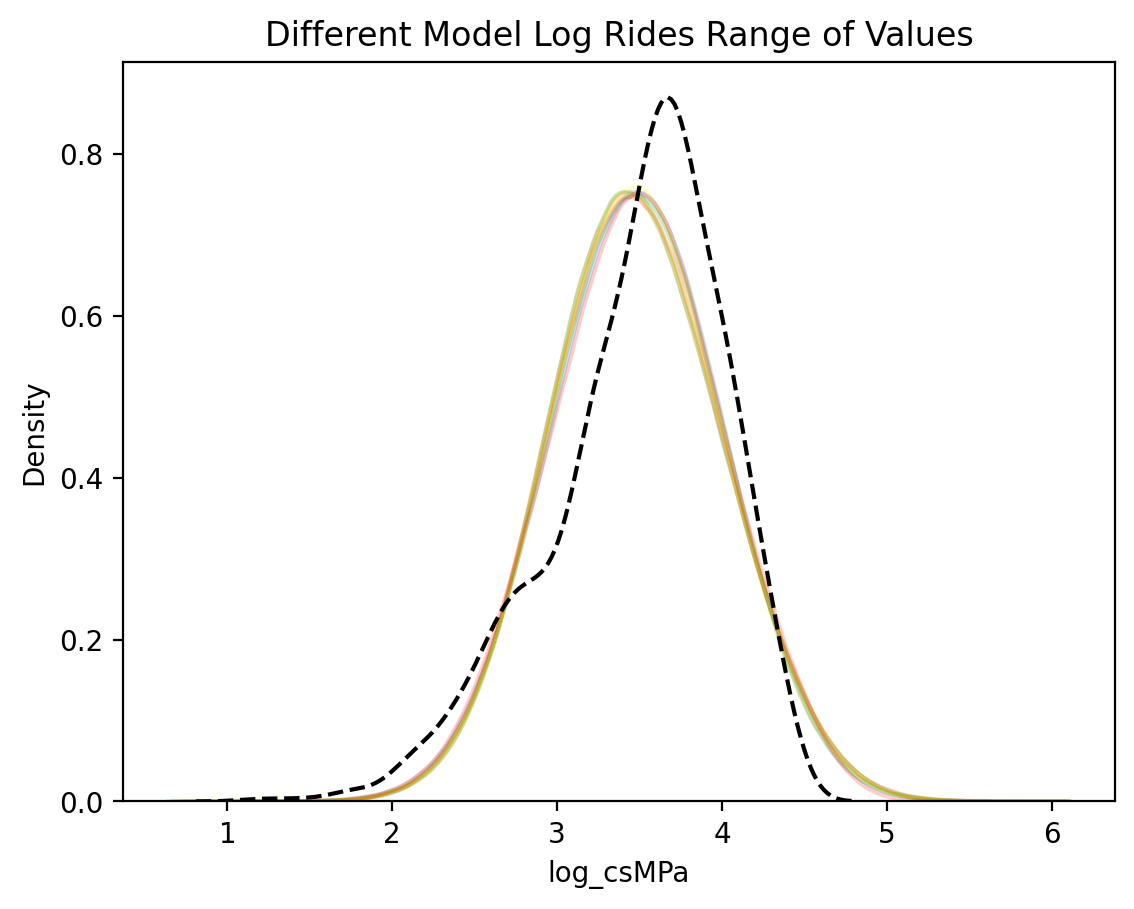

In [54]:
sns.kdeplot(logcsmpa_model1,alpha=0.2)
sns.kdeplot(logcsmpa_model2,color='green',alpha=0.2)
sns.kdeplot(logcsmpa_model3,color='yellow',alpha=0.2)
sns.kdeplot(logcsmpa_model4,color='red',alpha=0.2)
sns.kdeplot(logcsmpa_model5,alpha=0.2)
sns.kdeplot(logcsmpa_model6,color='green',alpha=0.2)
sns.kdeplot(logcsmpa_model7,color='yellow',alpha=0.2)
sns.kdeplot(logcsmpa_model8,color='red',alpha=0.2)
sns.kdeplot(data['log_csMPa'],color='black',linestyle='--',label='observed data')
plt.title('Different Model Log Rides Range of Values')

we see that using different model spesification, does not change how the values for posterior, so what do you think by adding complexity ? can you observe any significant changes ? 


What if you have numerous models to compare at the same time ? 

- There is interesting research paper on that, you can read more [projection
predictive variable selection](https://avehtari.github.io/modelselection/bodyfat.html)


## Evaluating and Comparing Model 

--- 

### Evaluating Model

There are many ways to calculate model performance. One of the robust way is to calculate model metrics through **Leave One Out Cross Validation**

Since most of the models requires log likelihood, we need to calculate it first

In [56]:
with model1 : 
    loglike_model1 = pm.compute_log_likelihood(model1_trace)
with model2 : 
    loglike_model2 = pm.compute_log_likelihood(model2_trace)
with model3 : 
    loglike_model3 = pm.compute_log_likelihood(model3_trace)
with model4 : 
    loglike_model4 = pm.compute_log_likelihood(model4_trace)
with model5 : 
    loglike_model5 = pm.compute_log_likelihood(model5_trace)
with model6 : 
    loglike_model6 = pm.compute_log_likelihood(model6_trace)
with model7 : 
    loglike_model7 = pm.compute_log_likelihood(model7_trace)
with model8 :
    loglike_model8 = pm.compute_log_likelihood(model8_trace)

In [57]:
df_comp_waic = az.compare({"model1": loglike_model1, "model2": loglike_model2, "model3": loglike_model3, "model4": loglike_model4,"model5": loglike_model5, "model6": loglike_model6, "model7": loglike_model7, "model8": loglike_model8},ic='waic',scale='deviance')
df_comp_waic

rank    elpd_waic    p_waic    elpd_diff        weight         se  \
model8     0    -8.570462  9.512558     0.000000  1.000000e+00  50.706674   
model7     1  1068.967550  7.885930  1077.538011  9.675290e-09  48.508842   
model6     2  1080.275308  7.025556  1088.845770  8.517972e-09  48.901870   
model5     3  1081.049747  6.515542  1089.620208  8.481365e-09  48.646916   
model4     4  1127.053390  5.693969  1135.623851  6.474593e-09  49.429808   
model3     5  1153.687729  5.089529  1162.258191  5.338443e-09  49.836833   
model2     6  1229.312591  4.132373  1237.883053  4.033737e-09  52.897717   
model1     7  1344.426481  2.943677  1352.996943  0.000000e+00  47.836853   

              dse  warning     scale  
model8   0.000000    False  deviance  
model7  46.337738    False  deviance  
model6  46.624445    False  deviance  
model5  46.888885    False  deviance  
model4  48.796916    False  deviance  
model3  49.470087    False  deviance  
model2  53.714737    False  deviance  
model1  52.348182    False  deviance